# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.   

But how do you get your own data into PyTorch?   
    
One of the ways to do so is via: custom datasets.   

## Domain libraries
Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existiong data loading functions and customizable data loading functions.
    
**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn, optim

torch.__version__

'2.3.1+cu118'

In [2]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Tue Aug 13 16:54:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   38C    P8              19W / 240W |   1486MiB /  8192MiB |     34%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

Our dataset is a subset of the Food101 datase.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, its iportant to try things on a small scale and then increase the scale when necessary.

The whole point isto speed up how fast ypu can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('./data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory already exist... skipping download') 
else:
    print(f'{image_path} does not exist, creating one...')
    image_path.mkdir(parents=True, 
                     exist_ok=True)
    
# Download pizzam steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print('Downloading pizza, steak, sushi data...')
    f.write(request.content)
    
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data...')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exist... skipping download
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in "data\pizza_steak_sushi".
There are 3 directories and 0 images in "data\pizza_steak_sushi\test".
There are 0 directories and 25 images in "data\pizza_steak_sushi\test\pizza".
There are 0 directories and 19 images in "data\pizza_steak_sushi\test\steak".
There are 0 directories and 31 images in "data\pizza_steak_sushi\test\sushi".
There are 3 directories and 0 images in "data\pizza_steak_sushi\train".
There are 0 directories and 78 images in "data\pizza_steak_sushi\train\pizza".
There are 0 directories and 75 images in "data\pizza_steak_sushi\train\steak".
There are 0 directories and 72 images in "data\pizza_steak_sushi\train\sushi".


In [7]:
# Setup training and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write som code to:
1. Get all of the image paths
2. pick a random image path using Python's `random.choice()`
3. Get the image class name `Pathlib.Path.parent.stem`
4. Since we're working with images. let's open the image with Python's PIL
5. we'll then show the image and print metadata

data\pizza_steak_sushi\test\sushi\2394442.jpg
sushi
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
image class: sushi
image height: 408
image width: 512


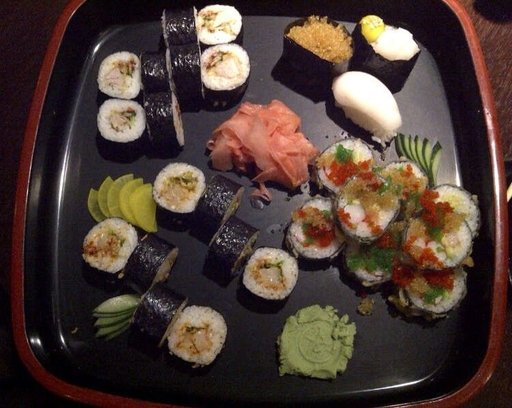

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"image class: {image_class}")
print(f"image height: {img.height}")
print(f"image width: {img.width}")
img

(-0.5, 511.5, 407.5, -0.5)

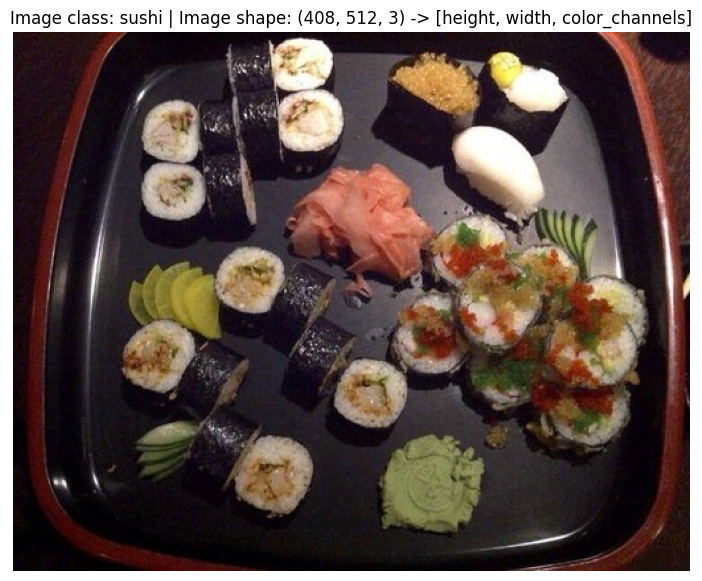

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

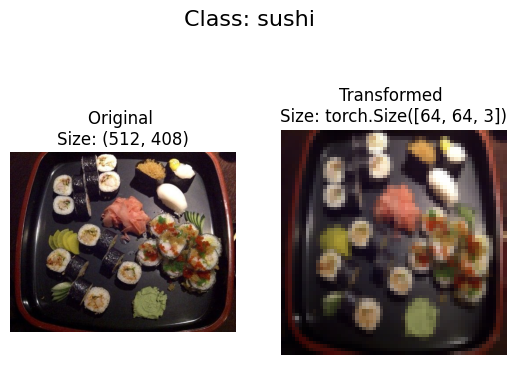

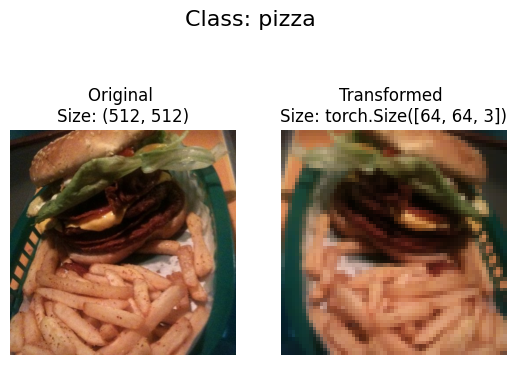

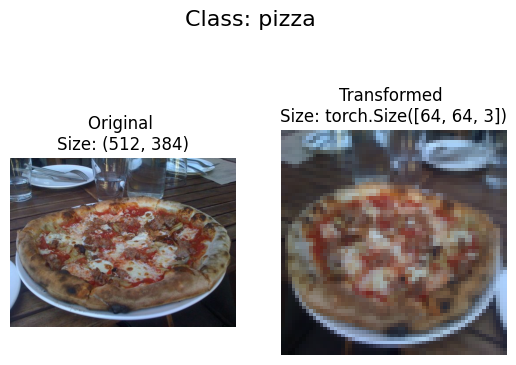

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [17]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

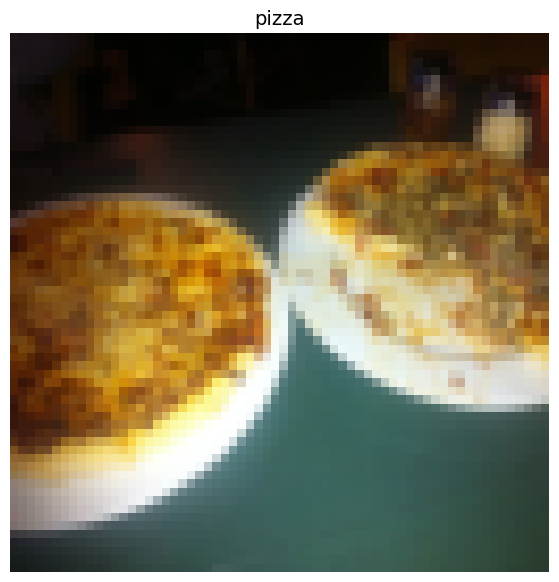

In [18]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [19]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2205dc0a0d0>,
 <torch.utils.data.dataloader.DataLoader at 0x2205db98350>)

In [20]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Createing helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification foramt)
2. Rise an error if the class names aren't found (if this happens, there might be something wrong woth the directory structure).
3. Turn the class names into a directory of numerical labels, one for each class

In [23]:
# setup path ofr target directory
target_directory = train_dir
print(f'Target directory: {target_directory}')

# Get the calss names form the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [24]:
def find_classes(directory: str)-> Tuple[List[str], Dict[str, int]]:
    """Find the class folder naems in a target directory."""
    # 1. Get the class names by scanning the target directory
    classes = sorted([entry.name for entry in list(os.scandir(target_directory))])
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    
    # 3. Create a directory of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [25]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Cretate a custon `Dataset` to replicate `ImageFolder`

To create our own coustom dataset, we wnat to:

1. Subclass `torch.utils.data.Dataset`.
2. Initour subclass with a target directory (the directory we'd liske ot get data from) as well as a transform if we'd like to transform our data
3. Create several attributes 
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the __len__ method to return the length of our dataset
6. Overwrite the __getitem__ method to return a given sample when passed an index

In [26]:
# Write a custom datset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Datset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom daataset
    def __init__(self, 
                 target_dirctory: str, 
                 transform=None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(target_dirctory).glob('*/*.jpg'))
        #Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(target_dirctory)
        
    # 4. Create a function to laod images
    def load_image(self, 
                   index: int) -> Image.Image:
        """Opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """Returns the total number of samples."""
        return len(self.paths)
    
    # 6. Overwrite __getitem__() method a retuen a particular sample
    def __getitem__(self, 
                    index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name #expect path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]
        
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)   
        else:
            return len(self.paths) # return untransformed image and label

In [27]:
# create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.ToTensor()
])

In [28]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(
    target_dirctory=train_dir, 
    transform=train_transforms, 
)

test_data_custom = ImageFolderCustom(
    target_dirctory=test_dir, 
    transform=test_transforms, 
)

In [29]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x2205dc14990>,
 <__main__.ImageFolderCustom at 0x2205dbec350>)

In [30]:
len(train_data), len(test_data)

(225, 75)

In [31]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [32]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [33]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDatset
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True


### 5.3 Create a function to display random images
1. Take in a `Dataset` nad a number of other parameters such as class names nad how many visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a list of random sample indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop throught the random sample indexes and them with matplotlib
7. Make sure the dimensions our images line up with matplotlib (HWC)

In [34]:
# 1. Create a function to take in dtaset
import torch.utils


def display_random_images(dataset: torch.utils.data.Dataset, 
                          classes: List[str] = None, 
                          n: int = 10, 
                          display_shape: bool = True, 
                          seed: int = None):
    # 2. Adjust display if n is too high:
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape dispaly.")
        
    # 3. Set the seed
    if seed:
        random.seed(seed)
    
    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)
    
    # 5. Setup plot
    plt.figure(figsize=(16, 8))
    
    # 6. Loop through random indexes and plot them with matplotlib
    for i, target_sample in enumerate(random_sample_idx):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]
        
        # 7. Adjust tensor dimensions for plotting
        target_image_adjust = target_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color channels]
        
        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(target_image_adjust)
        plt.axis(False)
        
        if classes:
            title = f"Class: {classes[target_label]}"
            
            if display_shape:
                title = title + f"\nshape: {target_image_adjust.shape}"
            plt.title(title)

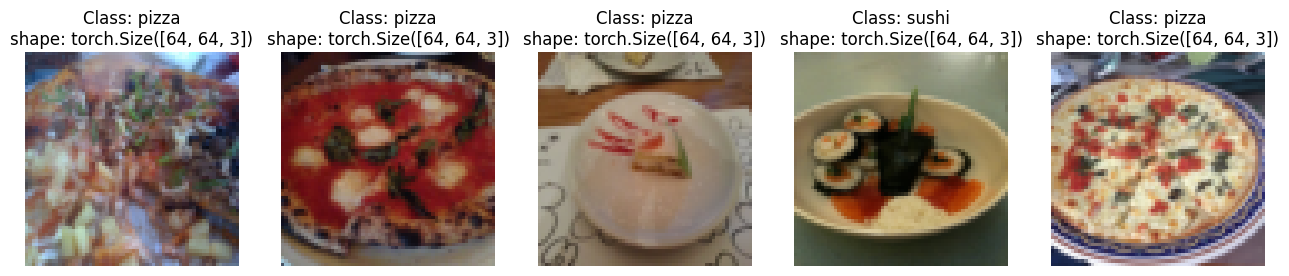

In [35]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names, 
                      seed=None)

For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape dispaly.


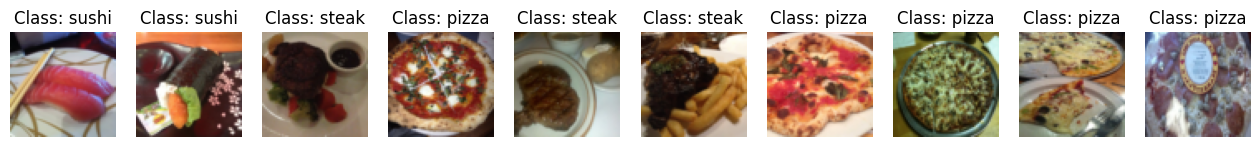

In [36]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data, 
                      n=20, 
                      classes=class_names, 
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [37]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=1, 
                                     num_workers=0, 
                                     shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) 

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2205dc0c3d0>,
 <torch.utils.data.dataloader.DataLoader at 0x2205bd7a210>)

In [38]:
# Get image and lav\bel form custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape


(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)
Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transforamtions to the training images.

This practice hopefullt results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentaion used to train PyTorch vision models to state of the art levels...

Blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements

In [39]:
# Let's look at trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), 
    transforms.TrivialAugmentWide(num_magnitude_bins=31), 
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), 
    transforms.ToTensor()
])

In [40]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

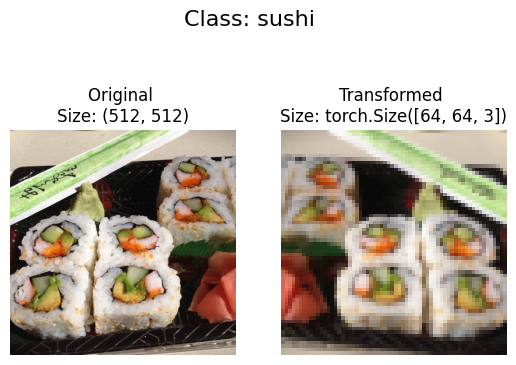

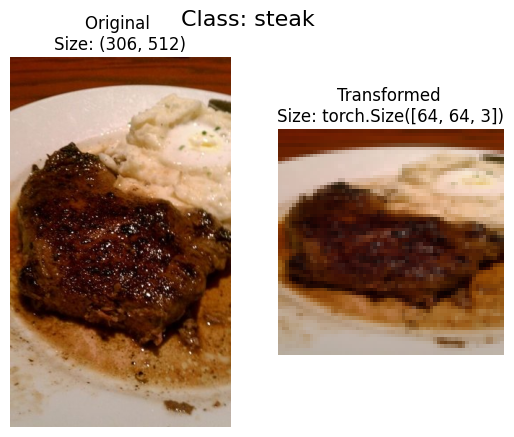

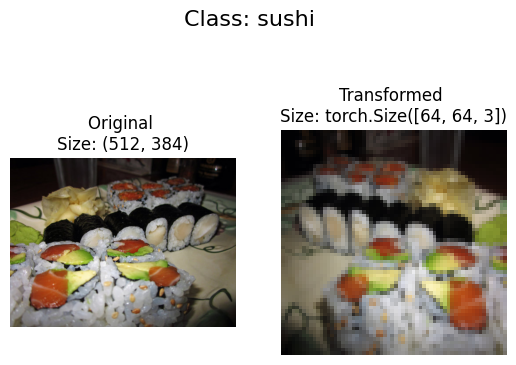

In [41]:
plot_transformed_images(image_paths=image_path_list, 
                        transform=train_transforms, 
                        n=3, 
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation
Let's replicate tinyVGG architecture from the CNN Explainer website

### 7.1 Creating transforms and loading data for Model 0

In [42]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), 
    transforms.ToTensor()   
])

In [43]:
# 1. Load and transform data
import torch.utils.data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root=train_dir, 
    transform=simple_transform
)

test_data_simple = datasets.ImageFolder(
    root=test_dir, 
    transform=simple_transform
)

# 2. Turn the datasets into Dataloader
import os
from torch.utils.data import DataLoader

# Setup batch size and number od works
BATCH_SIZE = 32
NUM_WORKERS = os. cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(
    dataset=train_data_simple, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS
)
train_dataloader_simple, test_data_simple

(<torch.utils.data.dataloader.DataLoader at 0x2205e201a10>,
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

### 7.2 Create TinyVGG model class

In [44]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer
    """
    def __init__(self, 
                 input_shape: int, 
                 hidden_units: int, 
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, 
                         stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=hidden_units*13*13, 
                      out_features=output_shape)
        )
        
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        x = self.classifier(x)
        print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # operator fusion

In [45]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [46]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [47]:
# Try a forward pass
model_0(image_batch.to(device))

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 3])


tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0047e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0238e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4989e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2689e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 use `torchinfo` to get an indea of the shapes going through our model

In [48]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 3])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [49]:
# Create train_step
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_function: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put the model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss Backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [50]:
# Create a test step
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_function: torch.nn.Module, 
              device=device):
    # Put the model in eval mode
    model.eval()
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference mode
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred_logits = model(X)
            
            # 2. Calculate the loss
            loss = loss_function(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_logits == y).sum().item() / len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc        
    

In [51]:
from tqdm.autonotebook import tqdm as notebook_tqdm
# 1. create a test function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer, 
          loss_function: torch.nn.Module = nn.CrossEntropyLoss(), 
          epochs: int = 5, 
          device=device):
    # 2. Create empty results dictionary
    results = {
        "train_loss": [], 
        "train_acc": [], 
        "test_loss": [], 
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in notebook_tqdm(range(1, epochs+1)):
        train_loss, train_acc = train_step(
            model=model, 
            dataloader=train_dataloader, 
            loss_function=loss_function, 
            optimizer=optimizer
        )
        
        test_loss, test_acc = test_step(
            model=model, 
            dataloader=test_dataloader, 
            loss_function=loss_function, 
            device=device
        )
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

c:\Users\user\anaconda3\envs\udemy-torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
